In [40]:
# Created by: Chen Da
# Created on: 20191217

In [70]:
import pandas as pd
import numpy as np
import random, warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')

In [71]:
def final_model(df):
    predict_score = list()
    for info in range(df.shape[0]):
        new_data = df.iloc[info, :].values[1:-1]
        z = np.dot(new_data, coefs) + intercept
        y = 1 / (1 + np.exp(-z))
        predict_score.append(y)
    predict_df = pd.DataFrame(predict_score, columns=['pro'])
    df.index = [i for i in range(df.shape[0])]
    predict_df['id'] = df['id']
    predict_df['class'] = df['class']
    predict_df = predict_df.reindex(columns=['id', 'pro', 'class'])
    positive = predict_df[predict_df['class'] == 1]
    negtive = predict_df[predict_df['class'] == 0]
    plt.figure(figsize=(20, 12))
    plt.scatter(x=positive['id'], y=positive['pro'], color='red')
    plt.scatter(x=negtive['id'], y=negtive['pro'], color='blue')
    plt.axhline(y=0.5, color='grey', linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()
    predict_df['pre_label'] = predict_df['pro'].apply(lambda x: round(x))
    predict_df['class'] = predict_df['class'].apply(lambda x: int(x))
    pre_0_right = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 0)].shape[0]
    pre_0_wrong = predict_df[np.logical_and(predict_df['class'] == 0, predict_df['pre_label'] == 1)].shape[0]
    pre_1_right = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 1)].shape[0]
    pre_1_wrong = predict_df[np.logical_and(predict_df['class'] == 1, predict_df['pre_label'] == 0)].shape[0]
    print('总体准确率为%s' % ((pre_0_right + pre_1_right) / predict_df.shape[0]))
    return predict_df

In [72]:
def split_func(data_frame, size=0.8):
    """
    Split the data into two data set
    :param data_frame: the name of input data
    :param size : the size of train data
    :return: train_data, test_data
    """
    data_frame = pd.DataFrame(data_frame.values,
                              index=[i for i in range(data_frame.values.shape[0])],
                              columns=data_frame.columns)
    healthy_data = data_frame[data_frame["class"] == 0]
    unhealthy_data = data_frame[data_frame["class"] == 1]
    healthy_index = list(healthy_data.index)
    unhealthy_index = list(unhealthy_data.index)
    healthy_train_data_index = random.sample(healthy_index, int(size * len(healthy_index)))
    unhealthy_train_data_index = random.sample(unhealthy_index, int(size * len(unhealthy_index)))
    healthy_test_data_index = list(set(healthy_index).difference(set(healthy_train_data_index)))
    unhealthy_test_data_index = list(set(unhealthy_index).difference(set(unhealthy_train_data_index)))
    train_index = list(set(healthy_train_data_index).union(set(unhealthy_train_data_index)))
    test_index = list(set(healthy_test_data_index).union(set(unhealthy_test_data_index)))
    train = data_frame.iloc[train_index, :]
    test = data_frame.iloc[test_index, :]
    return train, test

In [73]:
path = 'C:/Users/pc/OneDrive/PLTTECH/Project/20191217_colorectal_cancer/'
df_name = 'rawdata'
df = pd.read_excel(path + 'rawdata/' + df_name + '.xlsx')
df['id'] = df['id'].apply(lambda x:str(x))
pnasSubsetsIndex = [0, 4, 5, 18, 27, 28, 29, 30, 31, 37, 38, 43, 46,
                    58, 59, 60, 61, 62, 63, 64, 69, 70, 71, 72, 75, 76, 77,
                    80, 81, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 103
                    ]       
df = df.iloc[:, pnasSubsetsIndex]
df.iloc[:, 1:-1] = df.iloc[:, 1:-1].multiply(100)

In [74]:
## 划分训练集和测试集
train_df, test_df = split_func(df)
X_train = train_df.iloc[:, 1:-1].values
y_train = train_df['class'].values.astype('int')
X_test = test_df.iloc[:, 1:-1].values
y_test = test_df['class'].values.astype('int')
# X_train = df.iloc[:, 1:-1].values
# y_train = df['class'].values.astype('int')

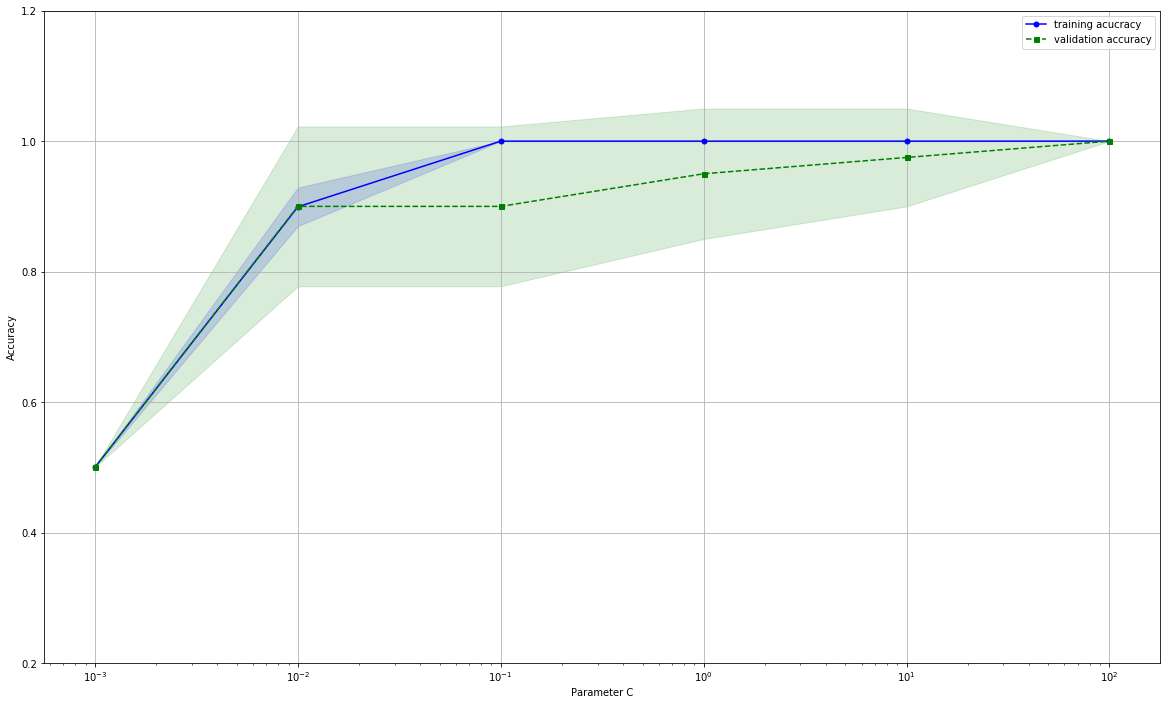

In [116]:
# 通过验证曲线来确定正则参数
# clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.7)
clf = LogisticRegression(penalty='l1')
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=clf, X=X_train, 
                                             y=y_train,
                                             param_name='C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(20,12))
plt.plot(param_range, train_mean, color='blue', marker='o',
         markersize=5, label='training acucracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std,
                 alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1.2])
plt.show()                # 图形观察出最优正则参数在0.1附近

In [107]:
lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.7, C=0.03)
lr.fit(X_train, y_train)

LogisticRegression(C=0.03, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.7, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
# help(LogisticRegression)

In [109]:
lr.score(X_train, y_train)

0.9375

In [110]:
lr.score(X_test, y_test)

0.875

In [111]:
coefs = list(lr.coef_[0])
intercept = lr.intercept_[0]
select_subsets_id = [list(lr.coef_[0]).index(i) for i in list(lr.coef_[0]) if i != 0]
select_subsets = [list(df.columns[1:-1])[i] for i in select_subsets_id]
print(len(select_subsets))
select_subsets.append('class')
select_subsets.insert(0, 'id')
print(select_subsets)
coefs = [i for i in coefs if i != 0]
print(coefs)
print(intercept)

11
['id', 'Lymphocytes/CD3+/CD4+/Q4: 158Gd_CD197_CCR7- , 155Gd_CD45RA-', 'Lymphocytes/CD3+/CD8+', 'Lymphocytes/CD3+/CD8+/CD28+', 'Lymphocytes/CD3+/CD8+/HLA-DR+', 'Lymphocytes/CD3+/CD8+/PD1+', 'Lymphocytes/CD3+/CD8+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3-/B cells', 'Lymphocytes/CD3-/B cells/Q3: 145Nd_IgD+ , 153Eu_CD27-', 'Monocytes/CD14+CD16-', 'Myeloid cells/CD56-CD14-/DC cells/mDC', 'Myeloid cells/HLA-DR-/MDSC', 'class']
[-0.024736735965397025, -0.012387253310093611, 0.020699208578712755, 0.01591912355838749, 0.010875263104511798, -0.00792026769993166, -0.011445987976632831, -0.06599128525934383, 0.05584978875755698, 0.0097366248916283, 0.03195791351215364]
-0.001125779856655436


In [112]:
# select_subsets = ['id', 'Lymphocytes/CD3+', 'Lymphocytes/CD3+/CD4+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3+/CD4+/T-bet+', 'Lymphocytes/CD3+/CD8+', 'Lymphocytes/CD3+/CD8+/PD1+', 'Lymphocytes/CD3+/CD8+/Q2: 158Gd_CD197_CCR7+ , 155Gd_CD45RA+', 'Lymphocytes/CD3-/B cells', 'Lymphocytes/CD3-/B cells/CD24+CD38+', 'Lymphocytes/CD3-/B cells/Q3: 145Nd_IgD+ , 153Eu_CD27-', 'Lymphocytes/CD3-/NK cells', 'Monocytes', 'Monocytes/CD14+CD16-', 'Myeloid cells/CD56-CD14-', 'Myeloid cells/CD56-CD14-/DC cells/mDC', 'Myeloid cells/HLA-DR-/MDSC', 'class']
# coefs = [-0.17459087521947694, -0.004137224142158975, 0.029210912177930624, -0.033894657615674284, 0.06442876779101712, -0.004016549751059136, 0.07100744274600215, 0.05962721355964336, -0.002214350131274935, -0.05124774662607224, 0.01349817395744002, 0.0033165355941261005, -0.02293159398330089, 0.10805642206114574, 0.06928411454818278]
# intercept = 0.0

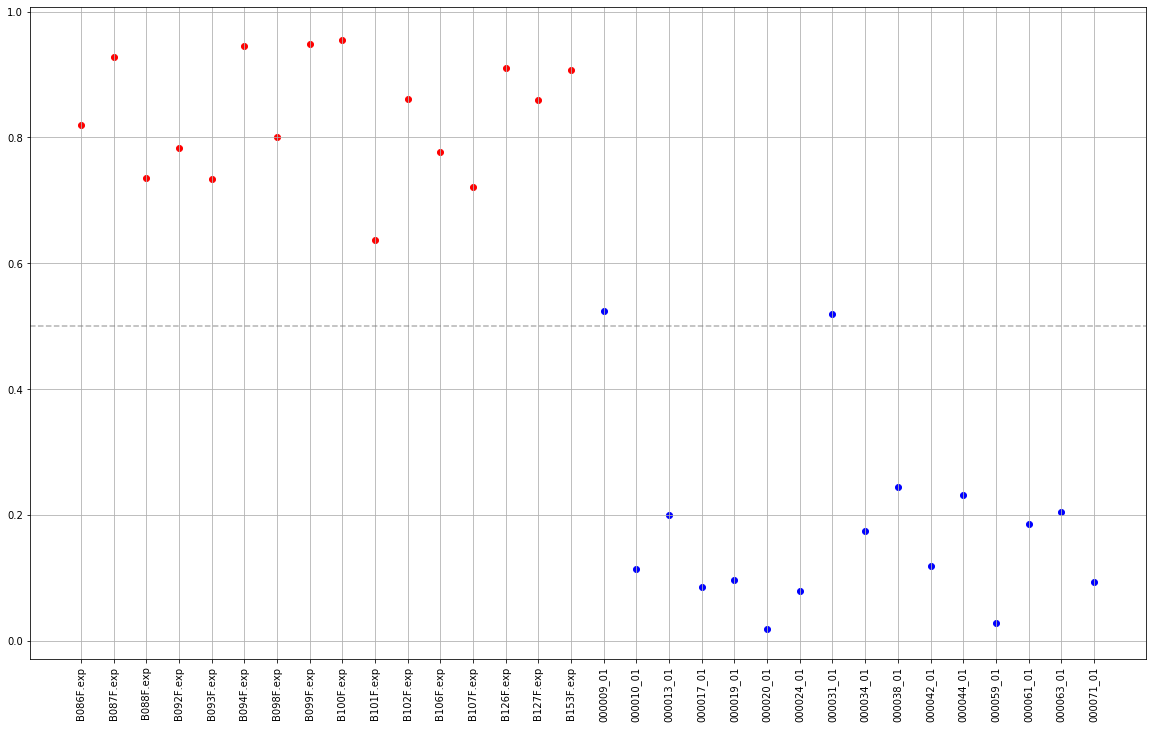

总体准确率为0.9375


In [113]:
pre_train = final_model(train_df.loc[:, select_subsets])

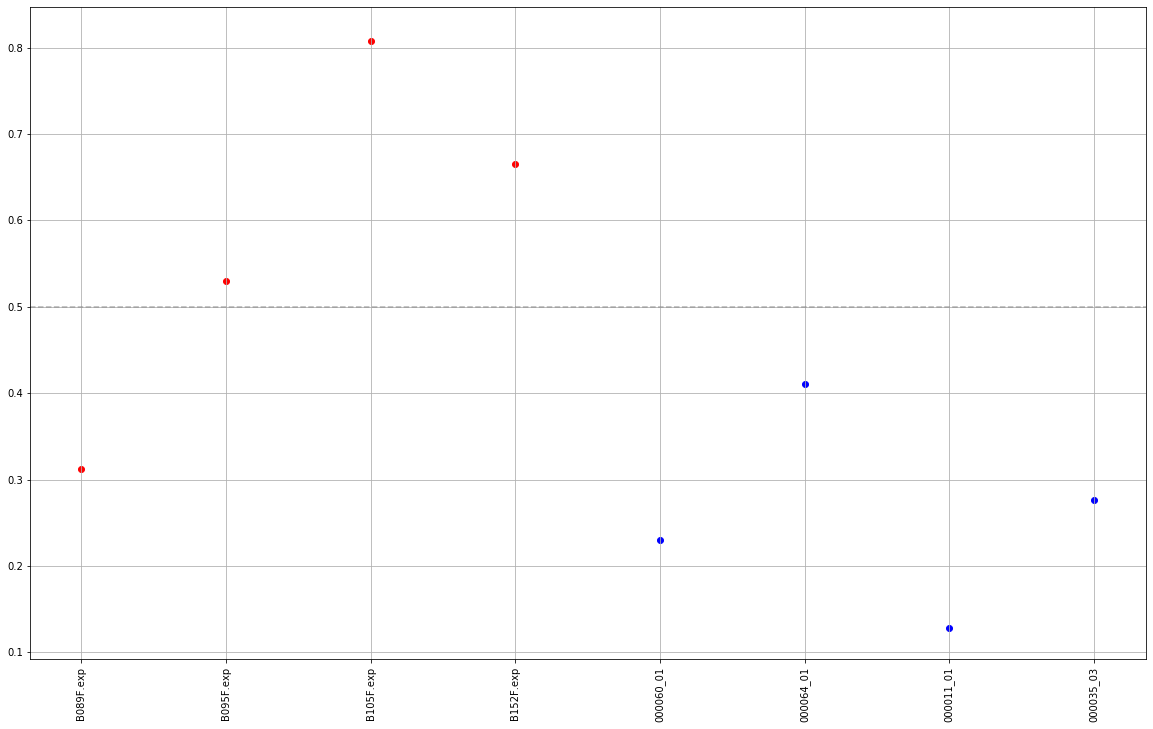

总体准确率为0.875


In [114]:
pre_test = final_model(test_df.loc[:, select_subsets])

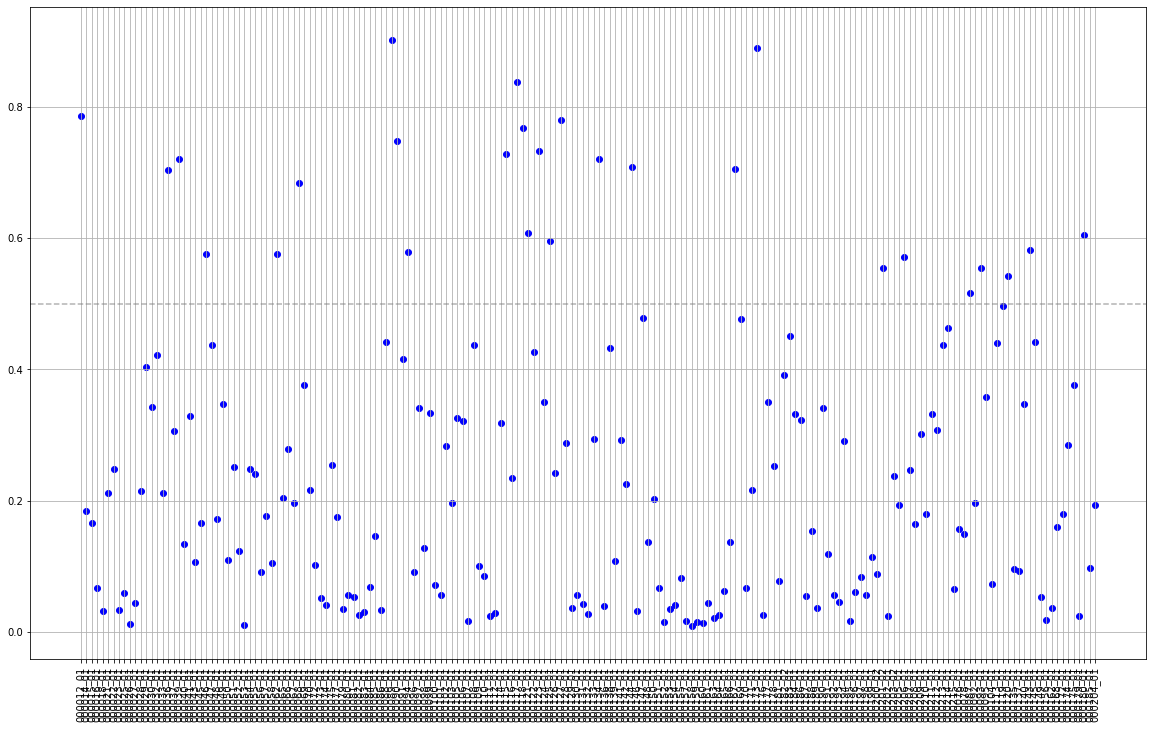

总体准确率为0.8556149732620321


In [115]:
healthy_new = pd.read_excel(path + 'rawdata/test_healthy_new.xlsx').loc[:, select_subsets]
healthy_new.iloc[:, 1:-1] = healthy_new.iloc[:, 1:-1].multiply(100)
pre_healthy = final_model(healthy_new)

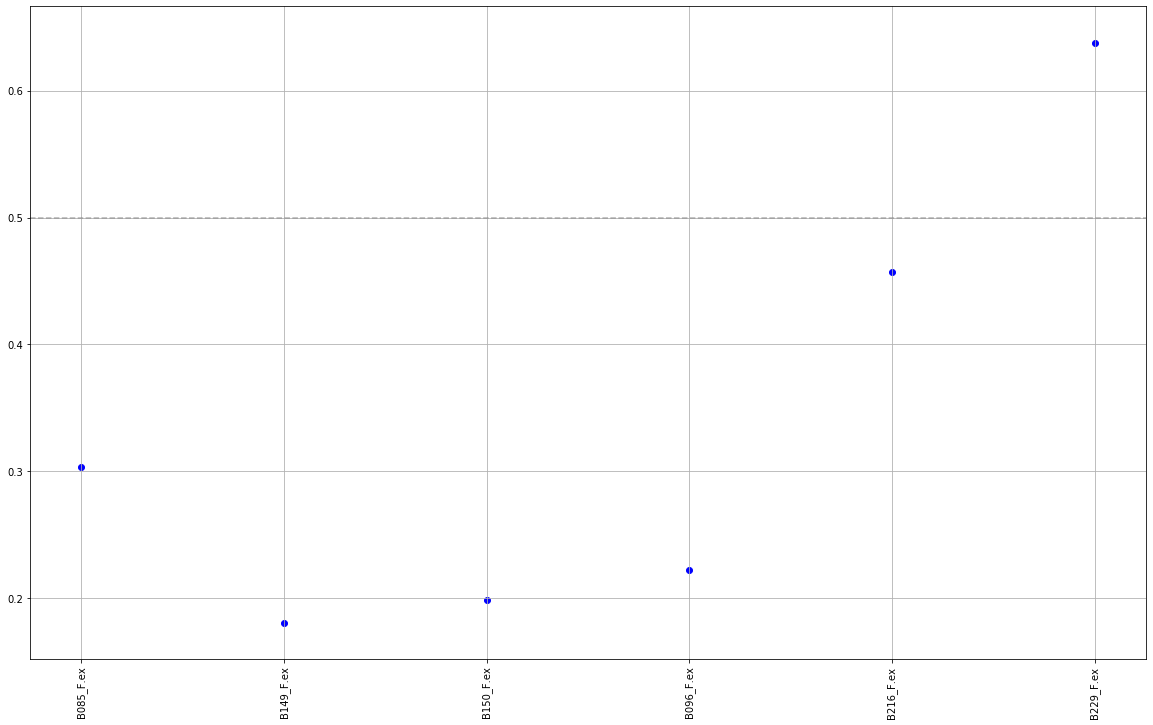

总体准确率为0.8333333333333334


In [105]:
PLT_healthy_new = pd.read_excel(path + 'rawdata/test_PLT_healthy.xlsx').loc[:, select_subsets]
PLT_healthy_new.iloc[:, 1:-1] = PLT_healthy_new.iloc[:, 1:-1].multiply(100)
pre_PLT = final_model(PLT_healthy_new)